In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm.auto import tqdm

In [2]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),     # LeNet-5 espera 32x32
    transforms.ToTensor(),    
    transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

images, labels = next(iter(train_loader))
print(images.shape) 
print(labels.shape)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 358kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.06MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.04MB/s]

torch.Size([64, 1, 32, 32])
torch.Size([64])


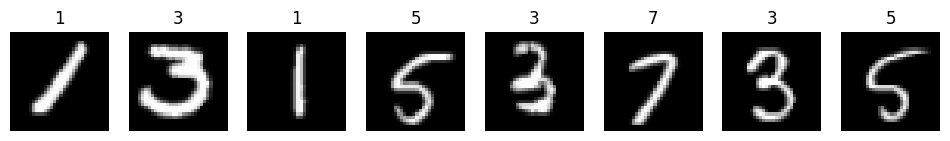

In [4]:
def denormalize(img_tensor):
    # Inversa de Normalize: img * std + mean
    return img_tensor * 0.3081 + 0.1307

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    img = denormalize(images[i]).squeeze(0)  
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{labels[i].item()}")
    ax.axis("off")

plt.show()

In [7]:
class ConvTanh(nn.Module):
    def __init__(self, in_c, out_c, k=5, s=1, p=0):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=True),
            nn.Tanh())
        
    def forward(self, x):
        return self.net(x)


class SubsampleAvgPool(nn.Module):
    """Emula el 'subsampling' del paper con avg-pool + tanh."""

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Tanh())
        
    def forward(self, x):
        return self.net(x)
    

In [8]:
class LeNet5(nn.Module):
    """
    Entrada: (N, 1, 32, 32)
    Arquitectura: C1(6) -> S2 -> C3(16) -> S4 -> C5(120) -> F6(84) -> Out(10)
    Notas:
      - Usamos conexiones 'densas' en C3 (estándar moderno). 
      - Activación tanh para ser fiel al paper.
    """

    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            ConvTanh(1, 6, k=5),          # 32->28 , 1->6.  28×28×6
            SubsampleAvgPool(),           # 28->14.  14×14×6
            ConvTanh(6, 16, k=5),         # 14->10 , 6 -> 16.  10×10×16
            SubsampleAvgPool(),           # 10->5 5×5×16
            ConvTanh(16, 120, k=5)        # 5->1 , 16 -> 120.  1×1×120
        )
        self.classifier = nn.Sequential(
            nn.Linear(120, 84),  # 84 neuronas 
            nn.Tanh(), # Tanh Activation 
            nn.Linear(84, num_classes))  # 10 clases Softmax

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def init_tanh_xavier(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
            if m.bias is not None:
                nn.init.zeros_(m.bias)


model = LeNet5(num_classes=10)
init_tanh_xavier(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  # They use the same optimizer 

In [25]:
@torch.no_grad()
def _topk_accuracies(logits, targets, ks=(1,)):
    """Devuelve un dict con top-k accuracies en %."""
    maxk = max(ks)
    batch_size = targets.size(0)

    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)  # [N, maxk]
    pred = pred.t()                                                # [maxk, N]
    correct = pred.eq(targets.view(1, -1).expand_as(pred))         # [maxk, N]

    out = {}
    for k in ks:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        out[f"top{k}"] = (correct_k.mul_(100.0 / batch_size)).item()
    return out


def train_epoch_classification(dataloader, model, optimizer, criterion, device=None, amp=False, desc="Train"):
    """
    Entrena una época (multiclase) con barra de progreso por batch.
    Muestra % completado y métricas en vivo (loss, acc@1, acc@3).
    """
    if device is None:
        device = next(model.parameters()).device
    elif isinstance(device, str):
        device = torch.device(device)
    device_type = device.type  # 'cuda' | 'cpu' | 'mps'


    model.train()
    running_loss = 0.0
    n_samples = 0
    correct1 = 0.0
    correct3 = 0.0

    use_amp = (amp and device_type == 'cuda')
    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    pbar = tqdm(dataloader, total=len(dataloader), leave=False, desc=desc)

    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.amp.autocast('cuda', enabled=True):
                logits = model(xb)           
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        bs = xb.size(0)
        running_loss += loss.item() * bs
        n_samples += bs

        # métricas por batch (top-1 y top-3)
        with torch.no_grad():
            maxk = 3
            _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
            correct = pred.eq(yb.view(-1, 1).expand_as(pred))  # [N,3]
            correct1 += correct[:, :1].reshape(-1).float().sum().item()
            correct3 += correct[:, :3].reshape(-1).float().sum().item()

        epoch_loss = running_loss / n_samples
        acc1 = 100.0 * (correct1 / n_samples)
        acc3 = 100.0 * (correct3 / n_samples)

        pbar.set_postfix(loss=f"{epoch_loss:.4f}", acc1=f"{acc1:.2f}%", acc3=f"{acc3:.2f}%")

    print(f"Train - loss: {epoch_loss:.4f} | acc@1: {acc1:.2f}% | acc@3: {acc3:.2f}%")
    return {'loss': epoch_loss, 'acc1': acc1, 'acc3': acc3}



def evaluate_classification(dataloader, model, criterion, device=None, return_preds=False, compute_top3=True):
    """
    Evalúa clasificación multiclase. Métricas: loss, acc@1 (y acc@3 opcional).

    Args:
        dataloader: iterable de (inputs, targets)
        model: nn.Module -> logits [N, C]
        criterion: nn.CrossEntropyLoss()
        device: opcional
        return_preds: si True, devuelve (pred_labels, true_labels, probs)
        compute_top3: si True, calcula acc@3 además de acc@1

    Returns:
        Si return_preds=False:
            dict {'loss': float, 'acc1': float, 'acc3': float (si aplica)}
        Si return_preds=True:
            (metrics_dict, pred_labels (list[int]), true_labels (list[int]), probs (list[list[float]]))
    """
    if device is None:
        device = next(model.parameters()).device


    model.eval()
    running_loss = 0.0
    n_samples = 0

    total_correct1 = 0.0
    total_correct3 = 0.0

    preds_all = []
    labels_all = []
    probs_all = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            logits = model(xb)                      # [N, C]
            loss = criterion(logits, yb)
            running_loss += loss.item() * xb.size(0)
            n_samples += xb.size(0)

            # Métricas
            topks = (1, 3) if compute_top3 else (1,)
            topk = _topk_accuracies(logits, yb, ks=topks)
            total_correct1 += topk['top1'] * xb.size(0) / 100.0
            if compute_top3:
                total_correct3 += topk['top3'] * xb.size(0) / 100.0

            if return_preds:
                probs = F.softmax(logits, dim=1)            # [N, C]
                _, pred = torch.max(logits, dim=1)          # [N]
                preds_all.extend(pred.cpu().tolist())
                labels_all.extend(yb.cpu().tolist())
                probs_all.extend(probs.cpu().tolist())

    metrics = {
        'loss': running_loss / n_samples,
        'acc1': 100.0 * (total_correct1 / n_samples)}
    
    if compute_top3:
        metrics['acc3'] = 100.0 * (total_correct3 / n_samples)

    if not return_preds:
        print_str = f"Val  - loss: {metrics['loss']:.4f} | acc@1: {metrics['acc1']:.2f}%"
        if compute_top3:
            print_str += f" | acc@3: {metrics['acc3']:.2f}%"
        print(print_str)
        return metrics
    else:
        return metrics, preds_all, labels_all, probs_all
    


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet5(num_classes=10).to(device)
init_tanh_xavier(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) 


In [33]:
epochs = 5 

for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train_metrics = train_epoch_classification(train_loader, model, optimizer, criterion, device=device, amp=False)


Epoch 1/5


Train - loss: 0.2632 | acc@1: 92.65% | acc@3: 98.42%
Epoch 2/5


Train - loss: 0.1939 | acc@1: 94.57% | acc@3: 98.94%
Epoch 3/5


Train - loss: 0.1542 | acc@1: 95.60% | acc@3: 99.24%
Epoch 4/5


Train - loss: 0.1276 | acc@1: 96.40% | acc@3: 99.44%
Epoch 5/5


Train - loss: 0.1083 | acc@1: 96.96% | acc@3: 99.56%


In [34]:
val_metrics = evaluate_classification(test_loader, model, criterion, device=device, return_preds=False)

Val  - loss: 0.0955 | acc@1: 97.21% | acc@3: 99.68%


In [35]:
def show_batch_images(images, labels, preds=None, n=16, title=None):
    """
    images: tensor [N,1,32,32] o lista de tensores
    labels: lista/array de ints
    preds : lista/array de ints (opcional)
    """
    n = min(n, len(images))
    cols = 8
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(2.2*cols, 2.6*rows))
    for i in range(n):
        img = denormalize(images[i].cpu()).squeeze(0)  # [H,W]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')

        if preds is None:
            plt.title(f"y={labels[i]}")
        else:
            ok = (preds[i] == labels[i])
            plt.title(f"y={labels[i]} | ŷ={preds[i]}", color=('green' if ok else 'red'))

        plt.axis('off')
    if title:
        plt.suptitle(title, y=1.02, weight='bold')
        
    plt.tight_layout()
    plt.show()

def visualize_test_predictions(model, test_loader, device='cpu', n=16, only_errors=False):
    """
    Toma batches del test_loader, corre el modelo y muestra un grid de imágenes
    con etiqueta real y predicción. Si only_errors=True, muestra solo mal clasificadas.
    """
    if isinstance(device, str):
        device = torch.device(device)

    model.eval()
    images_to_show = []
    labels_to_show = []
    preds_to_show  = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)                
            preds  = torch.argmax(logits, 1) 

            if only_errors:
                mask = preds.ne(yb)
            else:
                mask = torch.ones_like(yb, dtype=torch.bool)

            sel = mask.nonzero(as_tuple=False).squeeze(1)
            for idx in sel:
                images_to_show.append(xb[idx].cpu())
                labels_to_show.append(int(yb[idx].cpu()))
                preds_to_show.append(int(preds[idx].cpu()))
                if len(images_to_show) >= n:
                    break
            if len(images_to_show) >= n:
                break

    if len(images_to_show) == 0:
        print("No hay ejemplos que cumplan el criterio (quizá el modelo acertó todo ese batch).")
        return

    title = "Test samples (pred vs true)" if not only_errors else "Errores del modelo en test"
    show_batch_images(images_to_show, labels_to_show, preds_to_show, n=n, title=title)



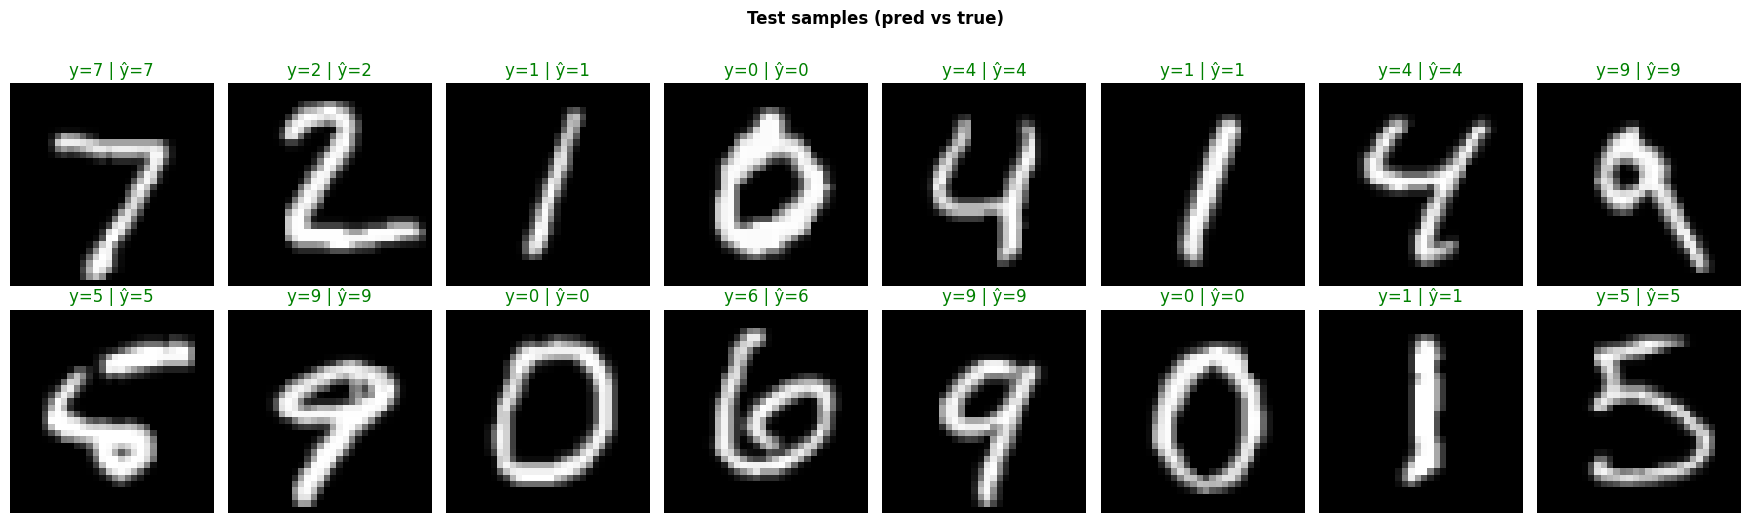

In [36]:
visualize_test_predictions(model, test_loader, device=device, n=16, only_errors=False)

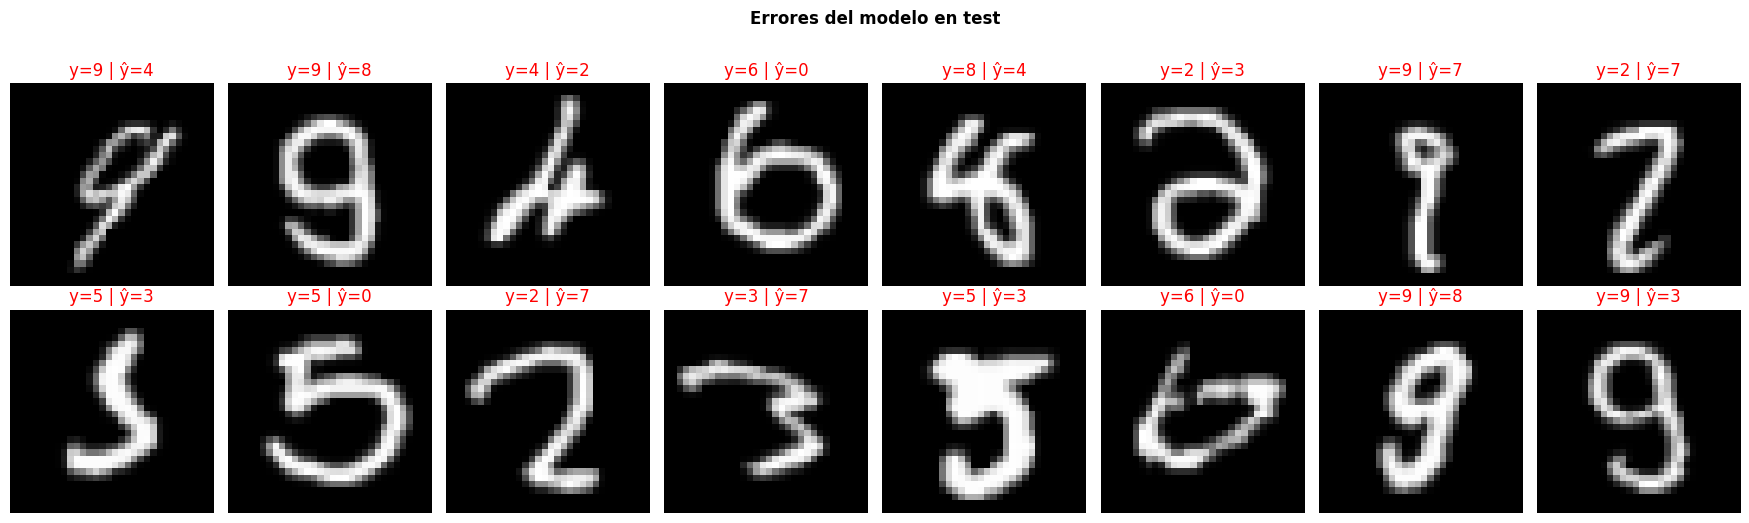

In [37]:
visualize_test_predictions(model, test_loader, device=device, n=16, only_errors=True)